<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/vae_mnist_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Variational) autoencoders with CNNs on MNIST  using PyTorch

Based on https://github.com/probml/pyprobml/blob/master/notebooks/vae_celeba_tf.ipynb. Translated to PyTorch by always-newbie161@ and murphyk@.

We use a 2d latent space so we can visualize things easily.


# Setup

In [1]:
import os
import time
import numpy as np

np.random.seed(0)
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

import sklearn
from sklearn import metrics

import seaborn as sns

sns.set(style="ticks", color_codes=True)

import pandas as pd

pd.set_option("precision", 2)  # 2 decimal places
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 30)
pd.set_option("display.width", 100)  # wide windows

In [10]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchvision.utils import make_grid
from random import randint
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!mkdir ./outputs

In [7]:
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/vae_helpers_pytorch.py
from vae_helpers_pytorch import *

# Load Mnist

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
    ]
)
# training set and train data loader
mnist_trainset = torchvision.datasets.MNIST(root="../input", train=True, download=True, transform=transform)
mnist_trainloader = DataLoader(mnist_trainset, batch_size=32, shuffle=True)
# validation set and validation data loader
mnist_testset = torchvision.datasets.MNIST(root="../input", train=False, download=True, transform=transform)
mnist_testloader = DataLoader(mnist_testset, batch_size=32, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../input/MNIST/raw/train-images-idx3-ubyte.gz to ../input/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../input/MNIST/raw/train-labels-idx1-ubyte.gz to ../input/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../input/MNIST/raw/t10k-images-idx3-ubyte.gz to ../input/MNIST/raw




Extracting ../input/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../input/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Model

In [11]:
encoder_conv_filters = [32, 64, 64, 64]
decoder_conv_t_filters = [64, 64, 32, 1]
Xsmall = next(iter(mnist_trainloader))[0][0, :]
models_mnist = {}
models_mnist["2d-det"] = ConvVAE(
    Xsmall.shape, encoder_conv_filters, decoder_conv_t_filters, 2, "2d-det", device, deterministic=True
).to(device)
models_mnist["2d-stoch"] = ConvVAE(
    Xsmall.shape, encoder_conv_filters, decoder_conv_t_filters, 2, "2d-stoch", device
).to(device)
summary(models_mnist["2d-det"], Xsmall.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
         LeakyReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
         LeakyReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]          36,928
         LeakyReLU-6             [-1, 64, 4, 4]               0
            Conv2d-7             [-1, 64, 2, 2]          36,928
         LeakyReLU-8             [-1, 64, 2, 2]               0
            Linear-9                    [-1, 2]             514
           Linear-10                    [-1, 2]             514
           Linear-11                  [-1, 256]             768
UpsamplingNearest2d-12             [-1, 64, 4, 4]               0
  ConvTranspose2d-13             [-1, 64, 4, 4]          36,928
        LeakyReLU-14             [-1,

# Training

In [16]:
images_to_recon = next(iter(mnist_trainloader))
print(images_to_recon[0].shape)
print(images_to_recon[1].shape)

torch.Size([32, 1, 32, 32])
torch.Size([32])


In [17]:
x, y = next(iter(mnist_trainloader))  # first batch
images_to_recon = x
nimages = 6
images_to_recon = images_to_recon[:nimages, :, :, :]
display_every_n_epochs = 1


def callback(model, epoch, train_epoch_loss, valid_epoch_loss):
    # display.clear_output(wait=False) # don't erase old outputs
    print(f"Training Losses on epoch {epoch}")
    print(train_epoch_loss)
    print(f"Validation Losses on epoch {epoch}")
    print(valid_epoch_loss)
    if epoch % display_every_n_epochs == 0:
        samples = model.generate_images(nimages)
        recon = model.reconstruct_images(images_to_recon)
        show_images(samples, ttl="samples")
        show_images(images_to_recon, ttl="input")
        show_images(recon, ttl="reconstruction")
        plt.show()

In [19]:
epochs = 2
lr = 0.001
optimizer = torch.optim.Adam(models_mnist["2d-det"].parameters(), lr=lr)
train_loss, valid_loss = training(
    models_mnist["2d-det"], mnist_trainloader, mnist_testloader, optimizer, epochs, callback=callback
)
fig, axs = plot_loss_histories(train_loss, valid_loss)
plt.show()

AttributeError: ignored

# 2d Embeddings for mnist

In [ ]:
N = int(len(mnist_testset))
images_mnist = torch.zeros(N, 1, 32, 32)
labels_mnist = torch.zeros(N)
bs = mnist_testloader.batch_size
c = 0
for i, b in enumerate(mnist_testloader):
    images_mnist[i * bs : (i + 1) * bs, :, :, :] = b[0]
    labels_mnist[i * bs : (i + 1) * bs] = b[1]

print(images_mnist.shape)
print(labels_mnist.shape)

torch.Size([10000, 1, 32, 32])
torch.Size([10000])


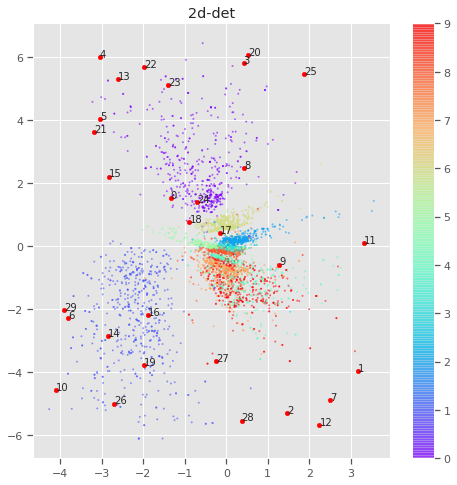

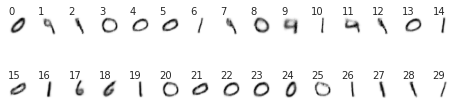

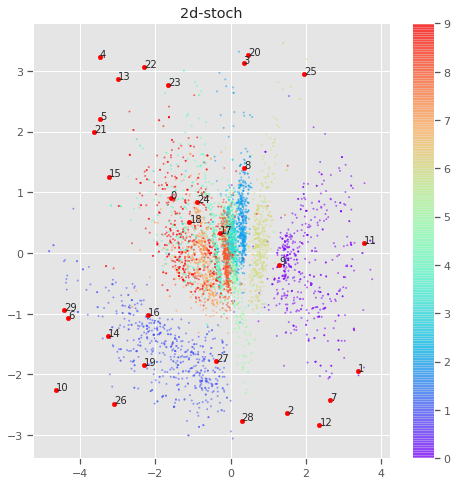

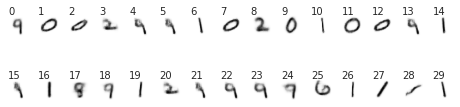

In [ ]:
# generate images from random points in latent space
def sample_from_embeddings(model, n_to_show=5000):
    figsize = 8
    np.random.seed(42)
    example_idx = np.random.choice(range(N), n_to_show)
    example_images = images_mnist[example_idx].to(device)
    example_labels = labels_mnist[example_idx]
    z_points, _ = model.encode(example_images)
    z_points = z_points.cpu().detach().numpy()

    plt.figure(figsize=(figsize, figsize))
    # plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
    plt.scatter(z_points[:, 0], z_points[:, 1], cmap="rainbow", c=example_labels, alpha=0.5, s=2)
    plt.colorbar()

    grid_size = 15
    grid_depth = 2
    np.random.seed(42)
    x_min = np.min(z_points[:, 0])
    x_max = np.max(z_points[:, 0])
    y_min = np.min(z_points[:, 1])
    y_max = np.max(z_points[:, 1])
    x = np.random.uniform(low=x_min, high=x_max, size=grid_size * grid_depth)
    y = np.random.uniform(low=y_min, high=y_max, size=grid_size * grid_depth)
    # x = np.random.normal(size = grid_size * grid_depth)
    # y = np.random.normal(size = grid_size * grid_depth)
    z_grid = np.array(list(zip(x, y)))
    t_z_grid = torch.FloatTensor(z_grid).to(device)
    reconst = model.decode(t_z_grid)
    reconst = reconst.cpu().detach()
    plt.scatter(z_grid[:, 0], z_grid[:, 1], c="red", alpha=1, s=20)
    n = np.shape(z_grid)[0]
    for i in range(n):
        x = z_grid[i, 0]
        y = z_grid[i, 1]
        plt.text(x, y, i)
    plt.title(model.model_name)
    plt.show()

    fig = plt.figure(figsize=(figsize, grid_depth))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(grid_size * grid_depth):
        ax = fig.add_subplot(grid_depth, grid_size, i + 1)
        ax.axis("off")
        # ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
        ax.text(0.5, -0.35, str(i))
        ax.imshow(reconst[i, :][0, :, :], cmap="Greys")


sample_from_embeddings(models_mnist["2d-det"])
sample_from_embeddings(models_mnist["2d-stoch"])

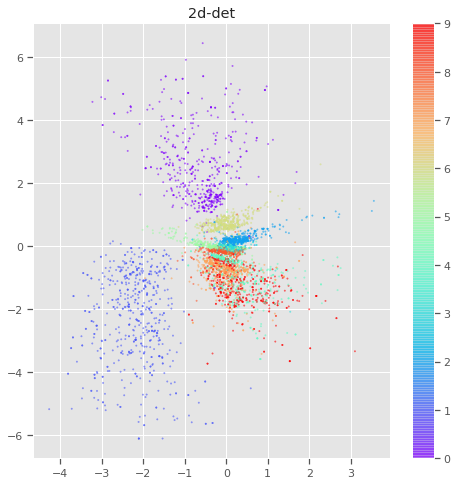

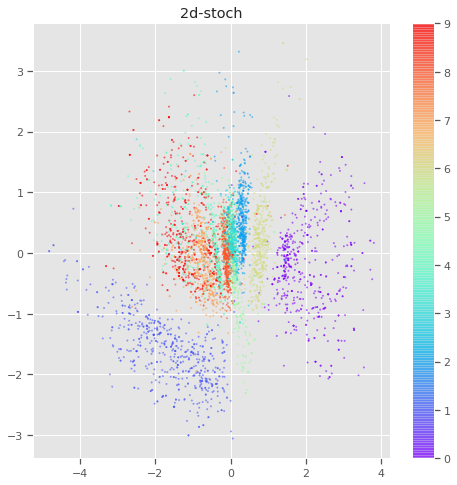

In [ ]:
# color code latent points
from scipy.stats import norm


def show_2d_embeddings(model, n_to_show=5000, use_cdf=False):
    figsize = 8

    np.random.seed(42)
    example_idx = np.random.choice(range(N), n_to_show)
    example_images = images_mnist[example_idx].to(device)
    example_labels = labels_mnist[example_idx]

    z_points, _ = model.encode(example_images)
    z_points = z_points.cpu().detach()
    p_points = norm.cdf(z_points)

    plt.figure(figsize=(figsize, figsize))
    if use_cdf:
        plt.scatter(p_points[:, 0], p_points[:, 1], cmap="rainbow", c=example_labels, alpha=0.5, s=5)
    else:
        plt.scatter(z_points[:, 0], z_points[:, 1], cmap="rainbow", c=example_labels, alpha=0.5, s=2)
    plt.colorbar()
    plt.title(model.model_name)
    plt.show()


show_2d_embeddings(models_mnist["2d-det"])
show_2d_embeddings(models_mnist["2d-stoch"])

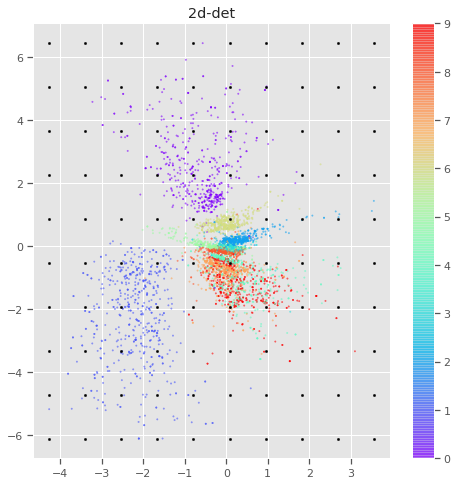

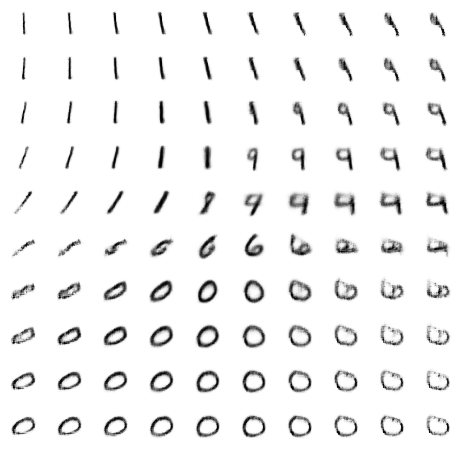

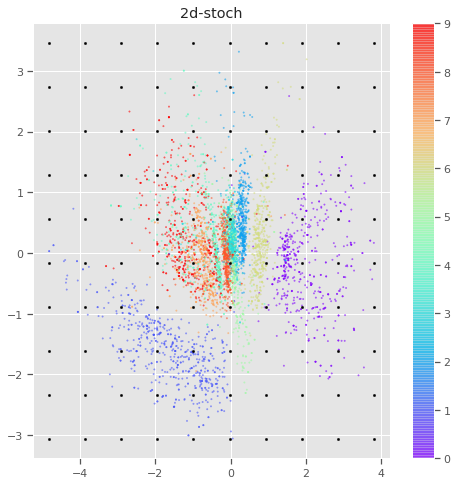

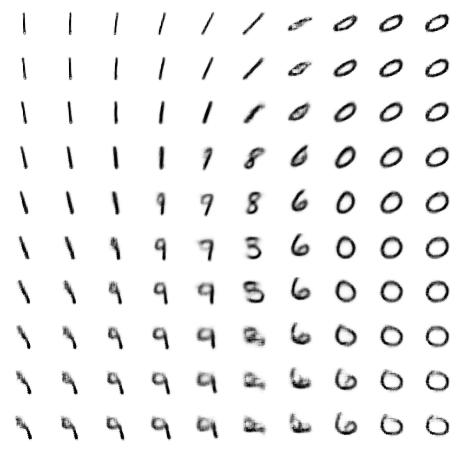

In [ ]:
# Generate images from 2d grid


def generate_from_2d_grid(model):
    n_to_show = 5000  # 500
    grid_size = 10
    figsize = 8
    np.random.seed(0)

    np.random.seed(42)
    example_idx = np.random.choice(range(N), n_to_show)
    example_images = images_mnist[example_idx].to(device)
    example_labels = labels_mnist[example_idx]
    z_points, _ = model.encode(example_images)
    z_points = z_points.cpu().detach().numpy()

    plt.figure(figsize=(figsize, figsize))
    plt.scatter(z_points[:, 0], z_points[:, 1], cmap="rainbow", c=example_labels, alpha=0.5, s=2)
    plt.colorbar()

    x_min = np.min(z_points[:, 0])
    x_max = np.max(z_points[:, 0])
    y_min = np.min(z_points[:, 1])
    y_max = np.max(z_points[:, 1])
    x = np.linspace(x_min, x_max, grid_size)
    y = np.linspace(y_min, y_max, grid_size)
    # x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
    # y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
    xv, yv = np.meshgrid(x, y)
    xv = xv.flatten()
    yv = yv.flatten()
    z_grid = np.array(list(zip(xv, yv)))
    t_z_grid = torch.FloatTensor(z_grid).to(device)
    reconst = model.decode(t_z_grid).cpu().detach()

    plt.scatter(z_grid[:, 0], z_grid[:, 1], c="black", alpha=1, s=5)  # , cmap='rainbow' , c= example_labels
    plt.title(model.model_name)
    plt.show()

    fig = plt.figure(figsize=(figsize, figsize))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(grid_size**2):
        ax = fig.add_subplot(grid_size, grid_size, i + 1)
        ax.axis("off")
        ax.imshow(reconst[i, :][0, :, :], cmap="Greys")
    plt.show()


generate_from_2d_grid(models_mnist["2d-det"])
generate_from_2d_grid(models_mnist["2d-stoch"])